In [1]:
using Revise

In [2]:
include("gp_utility.jl")

plot_gp_pred_realizations (generic function with 1 method)

In [3]:
using CmdStan
using CmdStanExtract

using DataFrames
using Plots
using Serialization
using Statistics

In [4]:
data = deserialize("gp.data")

(N = 11, x = -10.0:2.0:10.0, y = [-0.305988, -2.4159, -1.06836, 4.05275, 1.84246, -0.656602, -1.50408, 2.57574, -4.94042, -0.533326, -1.23523], N_predict = 501, x_predict = -10.0:0.04:10.0, y_predict = [-0.305988, 3.34174, -2.6149, 1.61098, 1.05581, -2.00876, -0.240148, -0.453517, 2.8017, 0.648663  …  -2.89914, 0.412148, -3.11129, -0.265462, -1.21106, 1.2445, 0.210053, 0.494353, -3.15261, -1.23523])

In [5]:
true_realization = deserialize("gp.truth")

(f_total = [0.440999, 0.450114, 0.459221, 0.468386, 0.477522, 0.486707, 0.495902, 0.505064, 0.514232, 0.523393  …  -1.01733, -1.01536, -1.0135, -1.01182, -1.01025, -1.00878, -1.0075, -1.00633, -1.00529, -1.00435], x_total = -10.0:0.04:10.0, sigma_true = 2)

In [6]:
simu_gauss_dgp = "
data {
  int<lower=1> N;
  real f[N];
  real<lower=0> sigma;
}

parameters {}
model {}

generated quantities {
  vector[N] y_predict;
  for (n in 1:N)
    y_predict[n] = normal_rng(f[n], sigma);
}
"

f_data = Dict(
    "sigma" => true_realization.sigma_true,
    "N" => length(true_realization.f_total),
    "f" => true_realization.f_total
)

dgp_fit = stan(Stanmodel(
    Sample(algorithm=CmdStan.Fixed_param()), 
    name="simu_gauss_dgp", model=simu_gauss_dgp, nchains=1, num_samples=1000, 
    random=CmdStan.Random(5838298)
), f_data, summary=false);



File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/simu_gauss_dgp.stan will be updated.



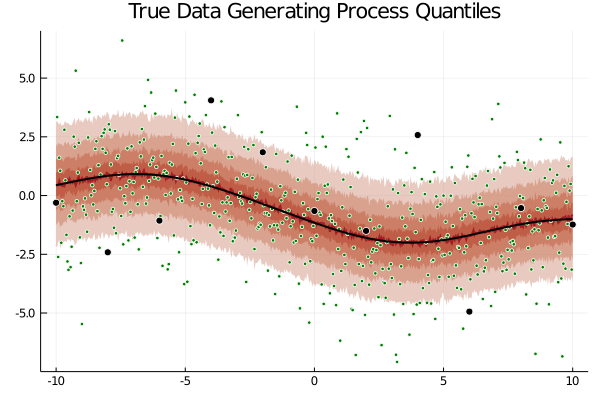

In [7]:
plot_gp_pred_quantiles(dgp_fit, data, true_realization,
                       "True Data Generating Process Quantiles")

In [8]:
opt1 = "
data {
  int<lower=1> N;
  real x[N];
  vector[N] y;
}

parameters {
  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

model {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(square(sigma), N));
  matrix[N, N] L_cov = cholesky_decompose(cov);

  y ~ multi_normal_cholesky(rep_vector(0, N), L_cov);
}
"

"\ndata {\n  int<lower=1> N;\n  real x[N];\n  vector[N] y;\n}\n\nparameters {\n  real<lower=0> rho;\n  real<lower=0> alpha;\n  real<lower=0> sigma;\n}\n\nmodel {\n  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)\n                     + diag_matrix(rep_vector(square(sigma), N));\n  matrix[N, N] L_cov = cholesky_decompose(cov);\n\n  y ~ multi_normal_cholesky(rep_vector(0, N), L_cov);\n}\n"

In [9]:
data_dict = Dict(String(key) => value for (key, value) in zip(keys(data), data))

Dict{String,Any} with 6 entries:
  "x_predict" => -10.0:0.04:10.0
  "N"         => 11
  "x"         => -10.0:2.0:10.0
  "N_predict" => 501
  "y_predict" => [-0.305988, 3.34174, -2.6149, 1.61098, 1.05581, -2.00876, -0.2…
  "y"         => [-0.305988, -2.4159, -1.06836, 4.05275, 1.84246, -0.656602, -1…

In [10]:
opt_fit = stan(Stanmodel(
    Optimize(), 
    name="opt1", model=opt1, 
    random=CmdStan.Random(5838298)
), data_dict, summary=false);


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/opt1.stan will be updated.



In [11]:
opt_fit

(0, Dict{Any,Any}("sigma" => [0.198458, 0.361359, 2.38237, 2.38085],:stan_patch_version => [0],:stan_minor_version => [24],"lp__" => [-15.0494, -15.0494, -15.0494, -15.0494],"alpha" => [2.37417, 2.35488, 0.0200152, 0.0875729],"rho" => [0.340846, 0.337526, 0.507225, 0.531776],:stan_major_version => [2]), ["lp__", "rho", "alpha", "sigma"])

In [12]:
alpha = opt_fit[2]["alpha"][1]
rho = opt_fit[2]["rho"][1]
sigma = opt_fit[2]["sigma"][1]

@show alpha rho sigma

alpha = 2.37417
rho = 0.340846
sigma = 0.198458


0.198458

In [13]:
predict_gauss = "
functions {
  vector gp_pred_rng(real[] x2,
                     vector y1, real[] x1,
                     real alpha, real rho, real sigma, real delta) {
    int N1 = rows(y1);
    int N2 = size(x2);
    vector[N2] f2;
    {
      matrix[N1, N1] K =   cov_exp_quad(x1, alpha, rho)
                         + diag_matrix(rep_vector(square(sigma), N1));
      matrix[N1, N1] L_K = cholesky_decompose(K);

      vector[N1] L_K_div_y1 = mdivide_left_tri_low(L_K, y1);
      vector[N1] K_div_y1 = mdivide_right_tri_low(L_K_div_y1', L_K)';
      matrix[N1, N2] k_x1_x2 = cov_exp_quad(x1, x2, alpha, rho);
      vector[N2] f2_mu = (k_x1_x2' * K_div_y1);
      matrix[N1, N2] v_pred = mdivide_left_tri_low(L_K, k_x1_x2);
      matrix[N2, N2] cov_f2 =   cov_exp_quad(x2, alpha, rho) - v_pred' * v_pred
                              + diag_matrix(rep_vector(delta, N2));
      f2 = multi_normal_rng(f2_mu, cov_f2);
    }
    return f2;
  }
}

data {
  int<lower=1> N;
  real x[N];
  vector[N] y;

  int<lower=1> N_predict;
  real x_predict[N_predict];

  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

transformed data {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, N));
  matrix[N, N] L_cov = cholesky_decompose(cov);
}

parameters {}
model {}

generated quantities {
  vector[N_predict] f_predict = gp_pred_rng(x_predict, y, x, alpha, rho, sigma, 1e-10);
  vector[N_predict] y_predict;

  for (n in 1:N_predict)
    y_predict[n] = normal_rng(f_predict[n], sigma);
}
"

pred_data = Dict(
    "alpha" => alpha, "rho" => rho, "sigma" => sigma, "N" => data.N, "x" => data.x, "y" => data.y,
    "N_predict" => data.N_predict, "x_predict" => data.x_predict
)

pred_opt_fit = stan(Stanmodel(
    Sample(algorithm=CmdStan.Fixed_param()), 
    name="predict_gauss", model=predict_gauss, nchains=1, num_samples=1000, 
    random=CmdStan.Random(5838298)
), pred_data, summary=false);


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/predict_gauss.stan will be updated.



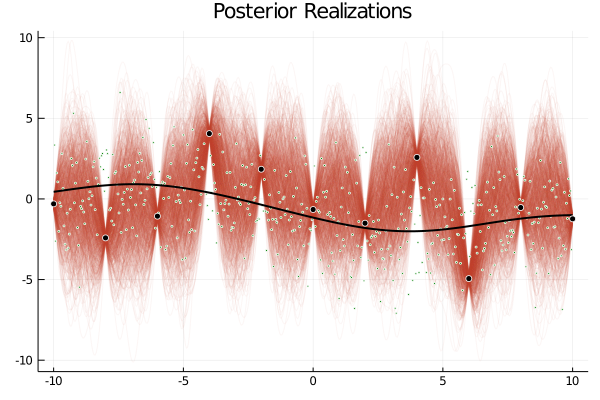

In [14]:
plot_gp_realizations(pred_opt_fit, data, true_realization,
                     "Posterior Realizations")


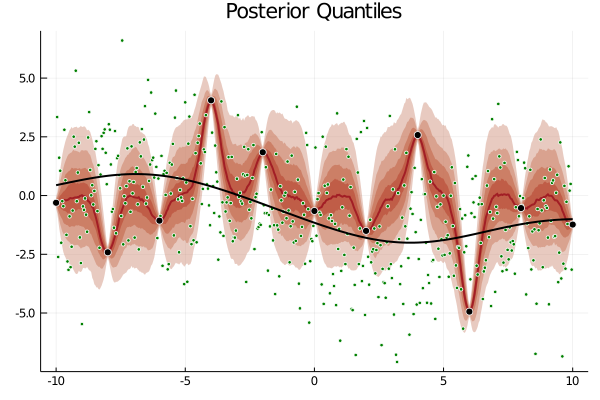

In [15]:
plot_gp_quantiles(pred_opt_fit, data, true_realization,
                  "Posterior Quantiles")


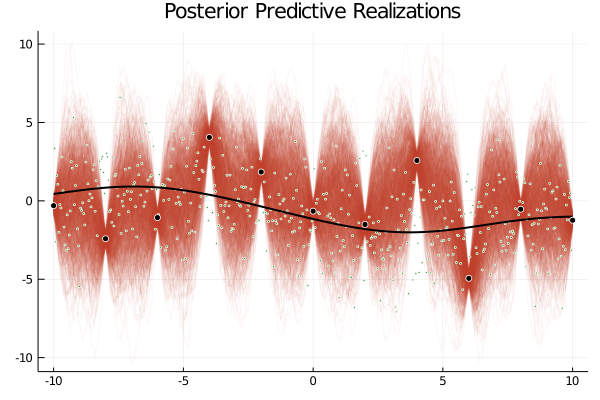

In [16]:
plot_gp_pred_realizations(pred_opt_fit, data, true_realization,
                     "Posterior Predictive Realizations")


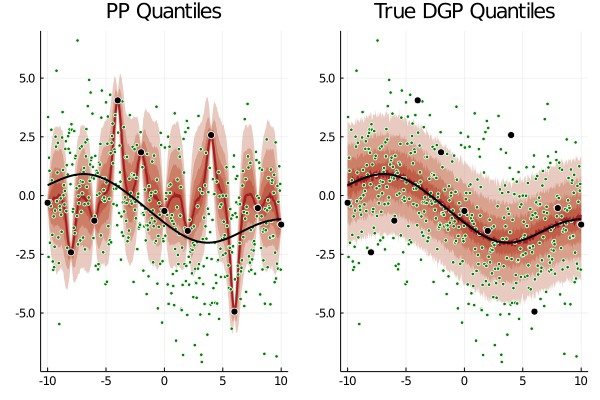

In [17]:
l = @layout [b c]
p1 = plot_gp_pred_quantiles(pred_opt_fit, data, true_realization,
                       "PP Quantiles")
p2 = plot_gp_pred_quantiles(dgp_fit, data, true_realization,
                       "True DGP Quantiles")
plot(p1, p2, layout = l)


In [18]:
opt_fit = stan(Stanmodel(
    Optimize(), 
    name="opt1", model=opt1, 
    random=CmdStan.Random(2384853)
), data_dict, summary=false);


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/opt1.stan will be updated.



In [19]:
alpha = opt_fit[2]["alpha"][1]
rho = opt_fit[2]["rho"][1]
sigma = opt_fit[2]["sigma"][1]

@show alpha rho sigma

alpha = 1.53893
rho = 0.234581
sigma = 1.81869


1.81869

In [20]:
pred_data = Dict(
    "alpha" => alpha, "rho" => rho, "sigma" => sigma, "N" => data.N, "x" => data.x, "y" => data.y,
    "N_predict" => data.N_predict, "x_predict" => data.x_predict
)

pred_opt_fit = stan(Stanmodel(
    Sample(algorithm=CmdStan.Fixed_param()), 
    name="predict_gauss", model=predict_gauss, nchains=1, num_samples=1000, 
    random=CmdStan.Random(5838298)
), pred_data, summary=false);


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/predict_gauss.stan will be updated.



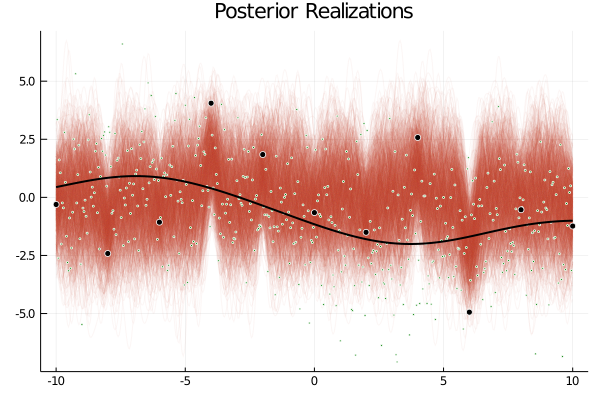

In [21]:
plot_gp_realizations(pred_opt_fit, data, true_realization,
                     "Posterior Realizations")


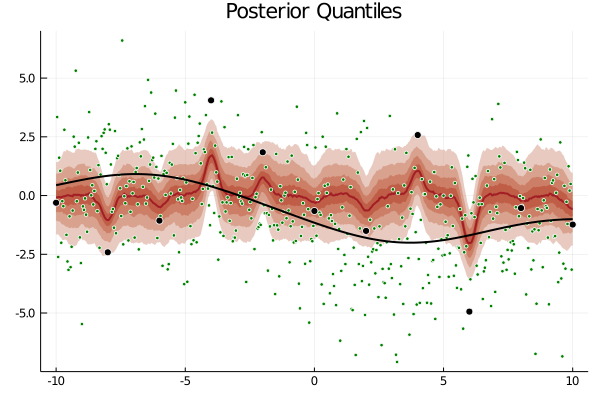

In [22]:
plot_gp_quantiles(pred_opt_fit, data, true_realization,
                  "Posterior Quantiles")


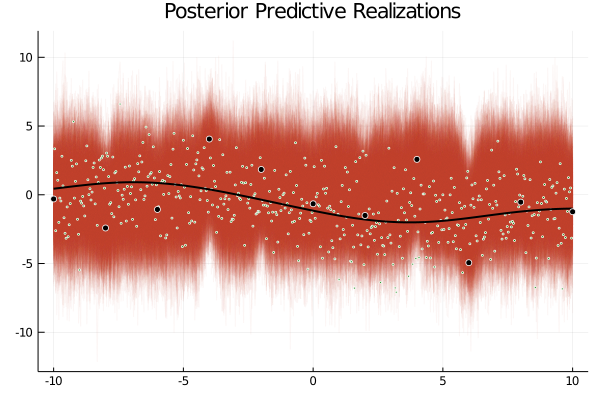

In [23]:
plot_gp_pred_realizations(pred_opt_fit, data, true_realization,
                     "Posterior Predictive Realizations")


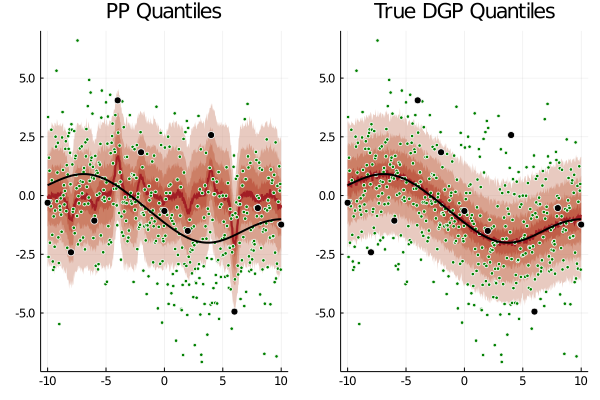

In [24]:
l = @layout [b c]
p1 = plot_gp_pred_quantiles(pred_opt_fit, data, true_realization,
                       "PP Quantiles")
p2 = plot_gp_pred_quantiles(dgp_fit, data, true_realization,
                       "True DGP Quantiles")
plot(p1, p2, layout = l)


In [25]:
opt2 = "
data {
  int<lower=1> N;
  real x[N];
  vector[N] y;
}

parameters {
  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> sigma;
}

model {
  matrix[N, N] cov =   cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(square(sigma), N));
  matrix[N, N] L_cov = cholesky_decompose(cov);

  rho ~ inv_gamma(8.91924, 34.5805);
  alpha ~ normal(0, 2);
  sigma ~ normal(0, 1);

  y ~ multi_normal_cholesky(rep_vector(0, N), L_cov);
}
"

opt_fit = stan(Stanmodel(
    Optimize(), 
    name="opt2", model=opt2, 
    random=CmdStan.Random(5838298)
), data_dict, summary=false);


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/opt2.stan will be updated.



In [26]:
alpha = opt_fit[2]["alpha"][1]
rho = opt_fit[2]["rho"][1]
sigma = opt_fit[2]["sigma"][1]

@show alpha rho sigma

alpha = 0.000470788
rho = 3.48597
sigma = 2.03159


2.03159

In [27]:
opt_fit = stan(Stanmodel(
    Optimize(), 
    name="opt2", model=opt2, 
    random=CmdStan.Random(95848338)
), data_dict, summary=false);


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/opt2.stan will be updated.



In [28]:
alpha = opt_fit[2]["alpha"][1]
rho = opt_fit[2]["rho"][1]
sigma = opt_fit[2]["sigma"][1]

@show alpha rho sigma

alpha = 0.000430941
rho = 3.48622
sigma = 2.0316


2.0316

In [29]:
pred_data = Dict(
    "alpha" => alpha, "rho" => rho, "sigma" => sigma, "N" => data.N, "x" => data.x, "y" => data.y,
    "N_predict" => data.N_predict, "x_predict" => data.x_predict
)

pred_opt_fit = stan(Stanmodel(
    Sample(algorithm=CmdStan.Fixed_param()), 
    name="predict_gauss", model=predict_gauss, nchains=1, num_samples=1000, 
    random=CmdStan.Random(5838298)
), pred_data, summary=false);


File /home/yiyuezhuo/notebooks5/Robust_Gaussian_Processes_in_Stan_and_Julia/tmp/predict_gauss.stan will be updated.



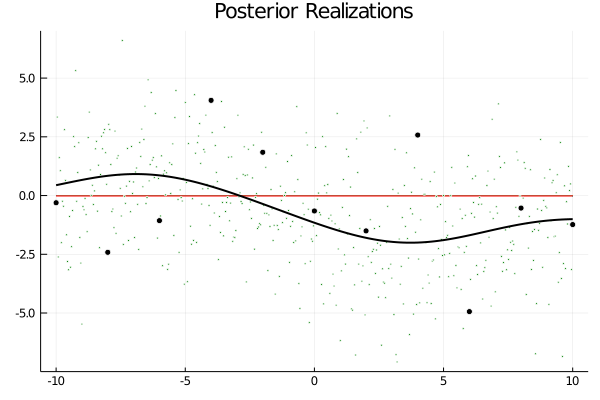

In [30]:
plot_gp_realizations(pred_opt_fit, data, true_realization,
                     "Posterior Realizations")


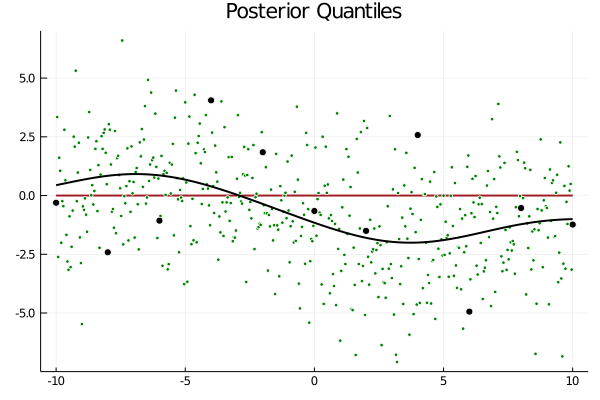

In [31]:
plot_gp_quantiles(pred_opt_fit, data, true_realization,
                  "Posterior Quantiles")


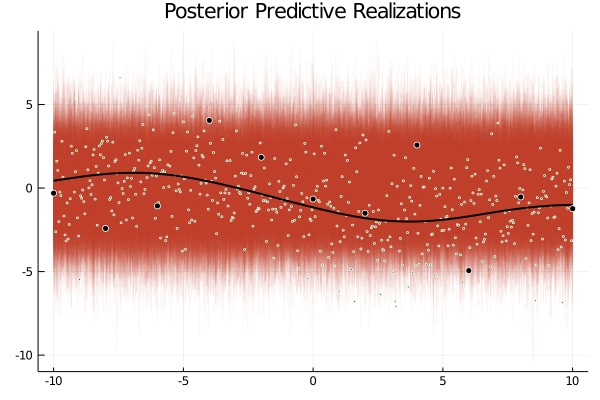

In [32]:
plot_gp_pred_realizations(pred_opt_fit, data, true_realization,
                     "Posterior Predictive Realizations")


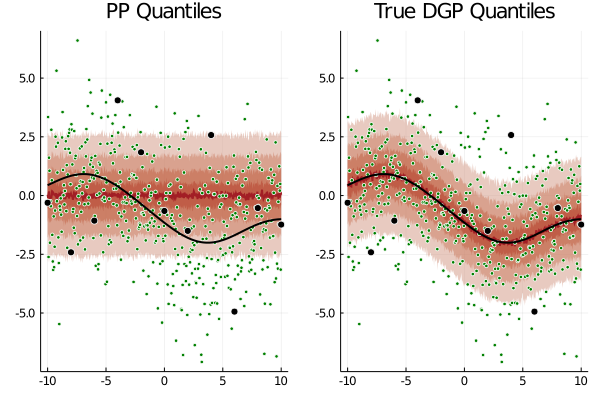

In [33]:
l = @layout [b c]
p1 = plot_gp_pred_quantiles(pred_opt_fit, data, true_realization,
                       "PP Quantiles")
p2 = plot_gp_pred_quantiles(dgp_fit, data, true_realization,
                       "True DGP Quantiles")
plot(p1, p2, layout = l)
